# Plot piControl, DECK along one time axis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import foci_functions

In [2]:
from dask.distributed import Client, LocalCluster, wait

In [3]:
cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit=16e9,
                       silence_logs=50)
client = Client(address=cluster)

In [4]:
client

Client Scheduler: tcp://127.0.0.1:43117 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 59.60 GiB


In [5]:
# Read CO2
exps = ['FOCI_GJK029',
        'FOCI_GJK030_r1i1p1',
        'FOCI_GJK031_r1i1p1',
        'FOCI_GJK032_r3i1p1']
names = ['piControl','historical','abrupt-4xCO2','1pctCO2']

ds_list = []
for i,exp in enumerate(exps):
    ds = xr.open_dataset('data/%s_forcing.nc' % (exp,), use_cftime=True)
    ds['expname'] = names[i]
    ds_list.append(ds)

In [35]:
# Read OpenIFS data
time_list = [slice('1850-01-01','2700-01-01'),
             slice('1850-01-01','2015-01-01'),
             slice('1850-01-01','2000-01-01'),
             slice('1850-01-01','2000-01-01')]

ds_sfc = foci_functions.read_openifs(exps, time_list, freq='1y')

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK029/outdata/oifs/ym/*1y*regular_sfc.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK030_r1i1p1/outdata/oifs/ym/*1y*regular_sfc.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK031_r1i1p1/outdata/oifs/ym/*1y*regular_sfc.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK032_r3i1p1/outdata/oifs/ym/*1y*regular_sfc.nc


In [36]:
# shift piControl axis to go from 1150 to 1850 so branch-offs look nice
new_time = xr.cftime_range("1150", periods=850, freq="Y")

In [37]:
ds_sfc[0]['time'] = new_time

In [22]:
# Read AMOC data
ds_amoc = foci_functions.read_amoc(exps, time_list)
# set new calendar so that 2450-2600 in piCtrl becomes 1850-2000
ds_amoc[0]['time'] = new_time

In [23]:
# Read ice data
ds_lim_1y = foci_functions.read_nemo(exps, time_list, grid='icemod',freq='1y')
ds_lim_1y[0]['time'] = new_time

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK029/outdata/nemo/ym/FOCI_GJK029*1y*icemod.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK030_r1i1p1/outdata/nemo/ym/FOCI_GJK030_r1i1p1*1y*icemod.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK031_r1i1p1/outdata/nemo/ym/FOCI_GJK031_r1i1p1*1y*icemod.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK032_r3i1p1/outdata/nemo/ym/FOCI_GJK032_r3i1p1*1y*icemod.nc


In [24]:
# Compute sea-ice area
nemo_mesh = foci_functions.read_nemo_mesh()

ds_ice = []
for i,ds in enumerate(ds_lim_1y):
    _ds = foci_functions.seaice_areas(ds, 
                                      nemo_mesh['tarea'], 
                                      nemo_mesh['tmask'].isel(deptht=0))
    ds_ice.append(_ds.compute())

In [38]:
# Compute global mean
tmean_list = [] 
for ds in ds_sfc:
    tm = foci_functions.global_mean(ds['2t'])
    tmean_list.append(tm.compute())

In [39]:
# Compute global mean

toa_list = [] 
for i,ds in enumerate(ds_sfc):
    
    # scale from J/m2 to W/m2
    # but not for 1pctCO2 run, where this scaling was already done
    if exps[i] == 'FOCI_GJK032_r3i1p1':
        scale = 1
    else:
        scale = (6.0*3600)
        
    tm = foci_functions.global_mean((ds['tsr'] + ds['ttr'])/scale)
    toa_list.append(tm.compute())

In [40]:
# Compute global mean
tp_list = [] 
for ds in ds_sfc:
    tp = foci_functions.global_mean(ds['tp']*4000)
    tp_list.append(tp.compute())

In [28]:
# Some observations we want to add
da_e5_t2m = xr.open_dataset('data/E5_1Y_T2M_globalmean.nc')['t2m'].isel(lon=0,lat=0)

In [29]:
da_gpcp_tp = xr.open_dataset('data/GPCP_1Y_globalmean.nc')['precip'].isel(lon=0,lat=0)

In [30]:
da_ceres_toa = xr.open_dataset('data/ceres_toa_globalmean.nc')['toa_net_all_mon'].isel(lon=0,lat=0)

In [31]:
da_hadisst_arctic = xr.open_dataset('data/hadisst_arctic.nc')['sic'].isel(lon=0,lat=0) * 1e-12

In [32]:
da_rapid_amoc = xr.open_dataset('data/rapid_amoc.nc')['moc_mar_hc10']

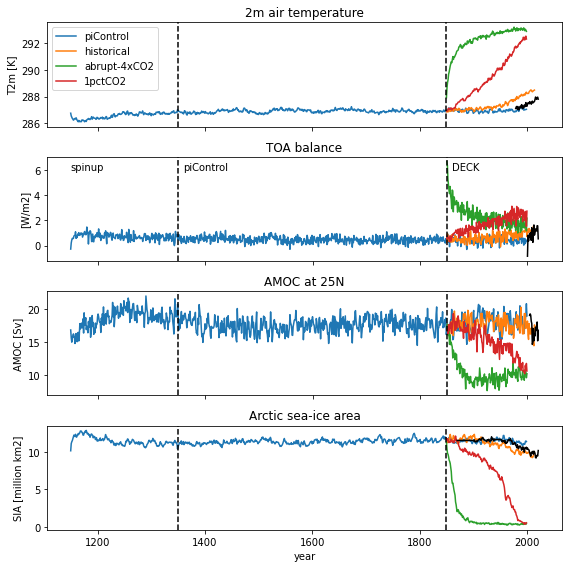

In [41]:
# Plot

fig, ax = plt.subplots(4,1, figsize=(8,8))
axs = ax.flat

for i,tm in enumerate(tmean_list):
    tm.groupby('time.year').mean('time').plot(ax=axs[0], label=names[i])
da_e5_t2m.groupby('time.year').mean('time').plot(ax=axs[0], color='k')
    
for i,tm in enumerate(toa_list):
    tm.groupby('time.year').mean('time').plot(ax=axs[1])    
da_ceres_toa.groupby('time.year').mean('time').plot(ax=axs[1], color='k')
    
for i,amoc in enumerate(ds_amoc):
    amoc['amoc25'].groupby('time.year').mean('time').plot(ax=axs[2])
da_rapid_amoc.groupby('time.year').mean('time').plot(ax=axs[2], color='k')
    
for i,ice in enumerate(ds_ice):
    ice['ar_sia'].groupby('time.year').mean('time').plot(ax=axs[3])
da_hadisst_arctic.groupby('time.year').mean('time').plot(ax=axs[3], color='k')
    
axs[0].legend()
axs[0].set_title('2m air temperature')
axs[0].set_ylabel('T2m [K]')

axs[1].set_title('TOA balance')
axs[1].set_ylabel('[W/m2]')

axs[2].set_title('AMOC at 25N')
axs[2].set_ylabel('AMOC [Sv]')

axs[3].set_title('Arctic sea-ice area')
axs[3].set_ylabel('SIA [million km2]')

axs[1].text(1150,6,'spinup')
axs[1].text(1360,6,'piControl')
axs[1].text(1860,6,'DECK')

for i,a in enumerate(axs):
    a.axvline(x=1850,linestyle='--',color='k')
    a.axvline(x=1350,linestyle='--',color='k')
    if i != len(axs)-1:
        a.set_xlabel('')
        a.set_xticklabels([])

fig.tight_layout()
fig.savefig('plots/deck_runs_all.pdf',format='pdf')

## Data references

* 2m air temperature from ERA-5. Hersbach et al. 2020, https://onlinelibrary.wiley.com/doi/abs/10.1002/qj.3803
* TOA balance from CERES EBAF v4.1. doi:10.5067/TERRA-AQUA/CERES/EBAF_L3B004.1
* AMOC from RAPID. Moat et al. (2022). doi:10.5285/e91b10af-6f0a-7fa7-e053-6c86abc05a09 
* Sea ice from HadISST. Rayner et al. (2003). http://doi.wiley.com/10.1029/2002JD002670